### 1. Importing necessary libraries

In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np

### 2. Plotting Daily Solutions for all Stations
using [UNAVCO webservices](https://www.unavco.org/data/web-services/documentation/documentation.html#!/GNSS47GPS/getPositionByStationId)

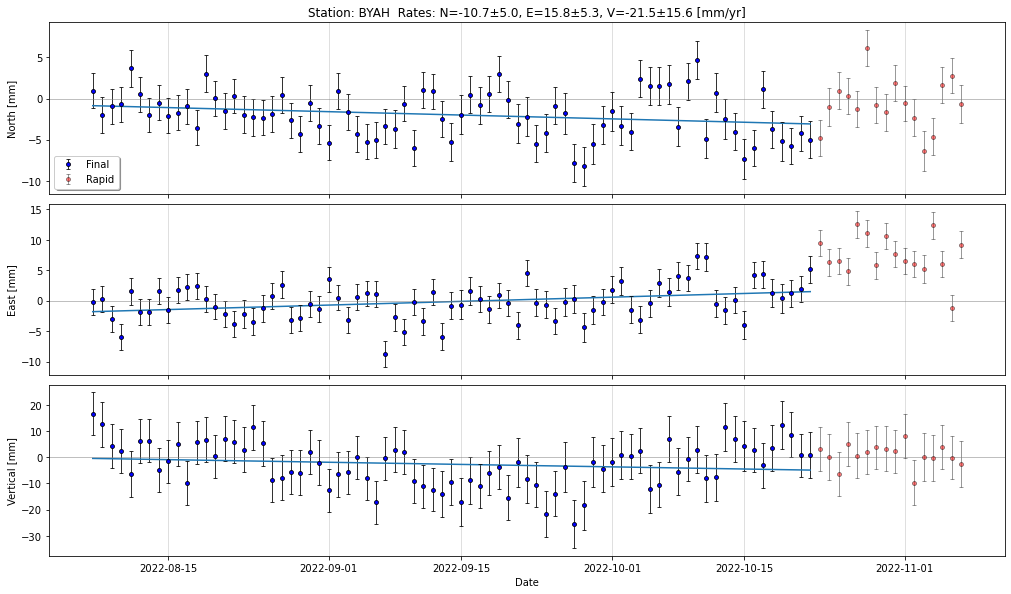

In [4]:
#creating url variable for each station
refFrame='nam14'
ancenter='cwu'
processing='Uncleaned'
refCoord='from_analysis_center'

yscale=1000 # to get to mm displacements
xscale=1/(86400e9*365.25) #convert numeric nanosecond into fractional year

Stats=('BNZA','BYAH', 'KANZ', 'NYBA', 'RUBO', 'IWAW', 'KMBR')
Stats=('BYAH',)
GetStats = False  # turn off for testing once data has been downloaded
#GetStats = True
nStats=len(Stats)
count=0

for stat in Stats:
    URL='https://web-services.unavco.org/gps/data/position/' + stat +\
    '/v3?analysisCenter=' + ancenter +\
    '&referenceFrame=' + refFrame +\
    '&report=long&dataPostProcessing=' + processing +\
    '&refCoordOptio='+ refCoord
    #URL='https://web-services.unavco.org/gps/data/position/'+stat+'/v3?analysisCenter=cwu&referenceFrame=nam14&report=long&dataPostProcessing=Uncleaned&refCoordOption=from_analysis_center'
    
    # plotting params
    
    # errors
    csize=2
    elw=0.8
    ecol='k'
    
    # markers 
    mec='k' #edge color
    mew=0.8 #width
    mfmt='o' # shape 
    msz='4' # size
    
    # final
    falpha=1
    fcol='blue'
    # rapid
    ralpha=0.5
    rcol='red'
    
    # grid
    galpha=0.5
    gvwidth=0.5
    ghwidth=1
    gcol='gray'
    
    
    #creating pandas readable csv from the url
    file=stat+'.csv'
    if GetStats:
        count += 1
        print('Requesting data for: '+stat+'  ['+str(count)+'/'+str(nStats)+']') # usable output
        req = requests.get(URL) # get data
        url_content = req.content
        csv_file = open(file, 'wb')
        csv_file.write(url_content)
        csv_file.close()
    df = pd.read_csv(file, header=8)
    df['Date'] =  pd.to_datetime(df['Datetime'])
    df['NumDate']=pd.to_numeric(df.Date)*xscale # converts to date in NANOseconds

    dfFinal=df.loc[df[' Solution']=='final']          #final solutions
    dfRapid=df.loc[df[' Solution']=='rapid']          #rapid solutions

    #creating Station (3 component) plots 
    #ax=(ax1, ax2, ax3)
    f, ax = plt.subplots(3, 1, figsize=(14,8),sharey=False, sharex=True) 
    f.tight_layout(h_pad=0)
    
    
    x=df['Date']
    xND=df['NumDate']
    xF=dfFinal['Date']
    xFND=dfFinal['NumDate']
    xR=dfRapid['Date']
    xRND=dfRapid['NumDate']
    sp=0
    slopes=np.zeros(3) # store slopes and errors
    errs=np.zeros(3)
    dfFNEU=pd.DataFrame()
    #dfFNEU=dfFinal[[' delta N',' delta E',' delta U',' Std Dev N',' Std Dev E',' Std Dev U']]*yscale
    
    Comps=('N','E', 'U')    
    for comp in Comps:
        ycolComp=str(' delta '+comp)
        wcolComp=str(' Std Dev '+comp)
        y=df[ycolComp]*yscale
        yF=dfFinal[ycolComp]*yscale
        yR=dfRapid[ycolComp]*yscale
        yeF=dfFinal[wcolComp]*yscale
        yeR=dfRapid[wcolComp]*yscale
        wghtF=1/(dfFinal[wcolComp]*yscale)**2
        
        # performing linear fits to data
        fit,var=np.polyfit(xFND,yF,1,w=wghtF, full=False, cov=True)
        fity=np.polyval(fit,xFND)
        slopes[sp]=fit[0]
        errs[sp]=np.sqrt(var[0][0])
        dfFNEU[ycolComp]=(yF-fity) # resetting column to be detrended sln for covariance determination
        dfFNEU[wcolComp]=(wghtF)  # resetting errors as weights 
        #plot
        ax[sp].plot(xF, fity)
        ax[sp].errorbar(x=xF, y=yF, yerr=yeF, 
                     fmt=mfmt, ms=msz, capsize=csize, label='Final', mfc=fcol, mec=mec, mew=mew, 
                     ecolor=ecol, elinewidth=elw, alpha=falpha)
        ax[sp].errorbar(x=xR, y=yR, yerr=yeR, 
                     fmt=mfmt, ms=msz, capsize=csize, label='Rapid', mfc=rcol, mec=mec, mew=mew, 
                     ecolor=ecol, elinewidth=elw, alpha=ralpha)
        #ax[sp].text(right,bottom,, ha='bottom',va='right')
        
        #plot labels and legend
        ax[sp].grid(axis='x', linestyle='-', color=gcol, linewidth=gvwidth, alpha=galpha)
        ax[sp].axhline(0, linestyle='-', color=gcol,linewidth=ghwidth, alpha=galpha) 
        if sp == 0 :
            ax[sp].legend(loc='lower left',fancybox=True, shadow=True)
            ax[sp].set_ylabel('North [mm]')
        
        if sp == 1 :
            ax[sp].set_ylabel('East [mm]')
        elif sp == 2 :
            ax[sp].set_ylabel('Vertical [mm]')
            ax[sp].set_xlabel('Date')
            # do last but plot atop
            ax[0].set_title('Station: '+stat+'  Rates: N=%.1f±%.1f, E=%.1f±%.1f, V=%.1f±%.1f [mm/yr]' % (slopes[0], errs[0],slopes[1], errs[1],slopes[2], errs[2]))
        sp+=1
    f.savefig(stat+'_TS.png', dpi=150, facecolor='white', bbox_inches='tight', pad_inches=0.5)

In [5]:
#NEU=dfFinal[[' delta N',' delta E',' delta U']]*yscale
cov=dfFNEU.cov()
print(cov)

             delta N   Std Dev N   delta E   Std Dev E    delta U   Std Dev U
 delta N    5.247874    0.000712  0.159431    0.001762   4.052808    0.000185
 Std Dev N  0.000712    0.000193 -0.004722    0.000146  -0.011327    0.000016
 delta E    0.159431   -0.004722  4.847481    0.000269  -0.955471   -0.000288
 Std Dev E  0.001762    0.000146  0.000269    0.000139  -0.009529    0.000013
 delta U    4.052808   -0.011327 -0.955471   -0.009529  19.900183   -0.001216
 Std Dev U  0.000185    0.000016 -0.000288    0.000013  -0.001216    0.000002


In [23]:
dfFinal=dfFinal.reset_index()

In [25]:
dfFinal.Date[0]      

Timestamp('2022-08-07 00:00:00+0000', tz='UTC')

In [27]:
def wcorr(df):
    """
    df contains N,E,U and Ne,Ee,Ue for dataset to determine
    the weighed covarience matrix 
    """ 
    Q=np.array(df[[' delta N',' delta E',' delta U']])
    W=np.array(df[[' Std Dev N',' Std Dev E',' Std Dev U']])
    QW=Q*W
    C=QW.T.dot(QW)/W.T.dot(W)
    return C
    
    

In [28]:
Q=np.array(dfFNEU[[' delta N',' delta E',' delta U']])
W=np.array(dfFNEU[[' Std Dev N',' Std Dev E',' Std Dev U']])
QW=Q*W
C=QW.T.dot(QW)/W.T.dot(W)

In [29]:
QW=Q*W
C=QW.T.dot(QW)/W.T.dot(W)

In [30]:
print(C)

[[ 4.99716068  0.11081992  3.73826201]
 [ 0.11081992  4.83851588 -1.14906159]
 [ 3.73826201 -1.14906159 18.80611501]]


In [31]:
C2=wcorr(dfFNEU)

In [32]:
print(C2)

[[ 4.99716068  0.11081992  3.73826201]
 [ 0.11081992  4.83851588 -1.14906159]
 [ 3.73826201 -1.14906159 18.80611501]]


In [33]:
dfFNEU.head()

,delta N,Std Dev N,delta E,Std Dev E,delta U,Std Dev U
0,4.178452,0.252519,-0.669055,0.285968,5.088871,0.020177
1,0.070021,0.245074,3.003434,0.282933,-5.481561,0.019506
2,0.011589,0.247519,-0.874076,0.285968,-0.631992,0.019837
3,-1.116843,0.250000,-4.131586,0.285968,5.417576,0.020006
4,2.674726,0.237954,2.100903,0.277008,-4.272855,0.019452


In [34]:
print(C2[0][0])

4.997160677190782


In [35]:
np.sqrt(C2)

<ipython-input-35-a698b237ccb9>:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(C2)


array([[2.235433  , 0.33289626, 1.93345856],
       [0.33289626, 2.19966267,        nan],
       [1.93345856,        nan, 4.33660178]])

In [36]:
C2.diagonal()

array([ 4.99716068,  4.83851588, 18.80611501])

In [37]:
errs=C2.diagonal()

In [38]:
errs[0]

4.997160677190782

In [39]:
from pyproj import transformer

ModuleNotFoundError: No module named 'pyproj'

In [40]:
URL='https://web-services.unavco.org/gps/data/position/'+stat+'/v3?analysisCenter=cwu&referenceFrame=nam14&report=long&dataPostProcessing=Uncleaned&refCoordOption=from_analysis_center'
req = requests.get(URL) # get data
url_content = req.content
csv_file = open(file, 'wb')
csv_file.write(url_content)
csv_file.close()